In [1]:
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn import ensemble
import urllib2, re, json, difflib
from bs4 import BeautifulSoup
from bs4 import Comment
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

In [5]:
#### Global Parameters ###

reloadData = True
saveFiles = True
year = 2017
teamList = []

doTest = False
doPower5 = False
doAll = True

verbose = 1

writeCSV = True

doPlotting = True
isGradientBoosted = False


In [6]:
teams = {}
win_pct = {}
opp_win_pct = {}

##hardcode all teams by conference for easy loading
teamListAAC = ['central-florida','south-florida','temple','east-carolina','cincinnati','connecticut','memphis','houston','navy','southern-methodist','tulane','tulsa']
teamListACC = ['clemson','north-carolina-state','wake-forest','boston-college','louisville','florida-state','syracuse','miami-fl','virginia-tech','georgia-tech','pittsburgh','virginia','duke','north-carolina']
teamListBigTwelve = ['oklahoma','texas-christian','oklahoma-state','texas','west-virginia','kansas-state','iowa-state','texas-tech','baylor','kansas']
teamListBigTen = ['ohio-state','penn-state','michigan-state','michigan','rutgers','maryland','indiana','wisconsin','northwestern','purdue','iowa','nebraska','minnesota','illinois']
teamListCUSA = ['florida-atlantic','florida-international','marshall','western-kentucky','middle-tennessee-state','old-dominion','charlotte','north-texas','alabama-birmingham','southern-mississippi','louisiana-tech','texas-san-antonio','rice','texas-el-paso']
teamListInd = ['massachusetts','notre-dame','army','brigham-young']
teamListMAC = ['akron','ohio','miami-oh','buffalo','bowling-green-state','kent-state','toledo','central-michigan','northern-illinois','western-michigan','eastern-michigan','ball-state']
teamListMWC = ['boise-state','wyoming','colorado-state','air-force','utah-state','new-mexico','fresno-state','san-diego-state','nevada-las-vegas','nevada','hawaii','san-jose-state']
teamListPACTwelve = ['stanford','washington','washington-state','oregon','california','oregon-state','southern-california','arizona-state','arizona','ucla','utah','colorado']
teamListSEC = ['georgia','south-carolina','kentucky','missouri','florida','vanderbilt','tennessee','auburn','alabama','louisiana-state','mississippi-state','texas-am','mississippi','arkansas']
teamListSunBelt = ['troy','arkansas-state','appalachian-state','georgia-state','louisiana-lafayette','louisiana-monroe','new-mexico-state','south-alabama','idaho','georgia-southern','coastal-carolina','texas-state']


In [7]:
defunctList = {'alabama-birmingham':2016, 'coastal-carolina':2016}

if doAll:
      doPower5 = True
      for team in teamListAAC: teamList.append(team)
      for team in teamListCUSA: teamList.append(team)
      for team in teamListMAC: teamList.append(team)
      for team in teamListMWC: teamList.append(team)
      for team in teamListSunBelt: teamList.append(team)
      teamList.append('massachusetts')
      teamList.append('army')
      teamList.append('brigham-young')

if doPower5:
      for team in teamListACC: teamList.append(team)
      for team in teamListBigTen: teamList.append(team)
      for team in teamListBigTwelve: teamList.append(team)
      for team in teamListPACTwelve: teamList.append(team)
      for team in teamListSEC: teamList.append(team)
      teamList.append('notre-dame')
      
if doTest:
      teamList.append('notre-dame')

if verbose > 1:
      iteam=0
      for team in teamList:
            print " loading team ",teamList[iteam]
            iteam+=1

In [8]:
if reloadData:
      
      #now get the opponent win percentage from another site
      if(year==2017):
            soup2 = BeautifulSoup(urllib2.urlopen("http://www.cpiratings.com/archives/{year}w15_table.html".format(year=year)).read(),'lxml')
      else:
            soup2 = BeautifulSoup(urllib2.urlopen("http://www.cpiratings.com/archives/{year}post_table.html".format(year=year)).read(),'lxml')
      teamTable = soup2.find_all('table')[0]
            
      rows = teamTable.find_all('tr')
      for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            cols[1] = re.sub("[\(\[].*?[\)\]]","",cols[1]).strip()
            teamArg = cols[1].lower().replace(" ", "-")
            if(teamArg=="team"):
                  continue
            if(teamArg=="smu"):
                  teamArg="southern-methodist"
            if(teamArg=="lsu"):
                  teamArg="louisiana-state"
            if(teamArg=="utep"):
                  teamArg="texas-el-paso"
            if(teamArg=="texas-st-san-marcos"):
                  teamArg="texas-state"
            if(teamArg=="unlv"):
                  teamArg="nevada-las-vegas"
            if(teamArg=="tcu"):
                  teamArg="texas-christian"
            #print teamArg
            teamClose = difflib.get_close_matches(teamArg,teamList,1,0.7)
            if(len(teamClose)==0):
                  print "cannot find any team matches for ",teamArg,"!"
                  continue
            teamClosest=teamClose[0]
            opp_win_pct.update({teamClosest: cols[13]})
            #print "opp win pct for ", teamClosest, "( ",teamArg," ) is ", cols[13]
      
      
      for team in teamList:
            if(team in defunctList):
                  if(defunctList[team]==year):
                        continue
            if verbose:
                  print "team: ",team
            soup = BeautifulSoup(urllib2.urlopen("https://www.sports-reference.com/cfb/schools/{school}/{year}/gamelog/".format(school=team, year=year)).read(),'lxml')
            parsed = soup.find_all("td")
            passTotal = int(parsed[len(parsed)-18].string)
            rushTotal = int(parsed[len(parsed)-15].string)
            firstDowns = int(parsed[len(parsed)-6].string)
            penalties = int(parsed[len(parsed)-4].string)
            turnTotal = int(parsed[len(parsed)-1].string)
            totalGameString = parsed[len(parsed)-25].string
            totalGames=int(re.split("(^\d+)",totalGameString)[1])
            
            record = unicode(soup.find_all("p")[2])
            pattern=re.compile("\d{1,2}")
            wins = int(pattern.findall(record)[0])
            losses = int(pattern.findall(record)[1])
            winPct = float(wins)/float(wins+losses)
            if verbose:
                  print "wins: ",wins, " losses: ",losses, " win pct: ",winPct
            win_pct.update({team: winPct})
            
            #the defensive stats are protected in a comment
            comments = BeautifulSoup(soup.find_all(string=lambda text:isinstance(text,Comment))[18].string,"lxml")
            parsed = comments.find_all("td")
            defTotal = int(parsed[len(parsed)-18].string) + int(parsed[len(parsed)-15].string)
            turnTotal = int(parsed[len(parsed)-1].string) - turnTotal
            
            teamInfo = [passTotal, rushTotal, firstDowns, penalties, defTotal, turnTotal]
            #for item in range(0,len(teamInfo)):
                  #teamInfo[item] = float(teamInfo[item])/float(totalGames)
            teams.update({team : teamInfo})
            
            if saveFiles:
                  file = open('{year}/{school}.txt'.format(year=year, school=team),'w')
                  fileContent = teamInfo
                  fileContent.append(winPct)
                  fileContent.append(opp_win_pct[team])
                  #fileContent = [passTotal,rushTotal,firstDowns,penalties,defTotal,turnTotal,winPct,opp_win_pct[team]]
                  json.dump(fileContent,file)
            if verbose:
                  print "games played: ",totalGames
                  print " passTotal: ",teamInfo[0], " rushTotal: ", teamInfo[1], " defTotal: ", teamInfo[4], " turnTotal: ", teamInfo[5], " opp win pct: ",opp_win_pct[team]
	

team:  central-florida
wins:  13  losses:  0  win pct:  1.0
games played:  13
 passTotal:  4313  rushTotal:  2589  defTotal:  5563  turnTotal:  17  opp win pct:  0.576
team:  south-florida
wins:  10  losses:  2  win pct:  0.833333333333
games played:  12
 passTotal:  2987  rushTotal:  3169  defTotal:  4317  turnTotal:  10  opp win pct:  0.443
team:  temple
wins:  7  losses:  6  win pct:  0.538461538462
games played:  13
 passTotal:  3273  rushTotal:  1773  defTotal:  4963  turnTotal:  -4  opp win pct:  0.520
team:  east-carolina
wins:  3  losses:  9  win pct:  0.25
games played:  12
 passTotal:  3815  rushTotal:  1297  defTotal:  6497  turnTotal:  -10  opp win pct:  0.603
team:  cincinnati
wins:  4  losses:  8  win pct:  0.333333333333
games played:  12
 passTotal:  2597  rushTotal:  1624  defTotal:  5142  turnTotal:  -5  opp win pct:  0.546
team:  connecticut
wins:  3  losses:  9  win pct:  0.25
games played:  12
 passTotal:  3230  rushTotal:  1756  defTotal:  6228  turnTotal:  -8  op

wins:  3  losses:  9  win pct:  0.25
games played:  12
 passTotal:  2814  rushTotal:  2018  defTotal:  5505  turnTotal:  1  opp win pct:  0.452
team:  san-jose-state
wins:  2  losses:  11  win pct:  0.153846153846
games played:  13
 passTotal:  2574  rushTotal:  1561  defTotal:  6491  turnTotal:  -26  opp win pct:  0.481
team:  troy
wins:  11  losses:  2  win pct:  0.846153846154
games played:  13
 passTotal:  3505  rushTotal:  1935  defTotal:  4400  turnTotal:  7  opp win pct:  0.481
team:  arkansas-state
wins:  7  losses:  5  win pct:  0.583333333333
games played:  12
 passTotal:  4106  rushTotal:  1833  defTotal:  4530  turnTotal:  -1  opp win pct:  0.391
team:  appalachian-state
wins:  9  losses:  4  win pct:  0.692307692308
games played:  13
 passTotal:  2811  rushTotal:  2907  defTotal:  4455  turnTotal:  12  opp win pct:  0.421
team:  georgia-state
wins:  7  losses:  5  win pct:  0.583333333333
games played:  12
 passTotal:  3248  rushTotal:  1414  defTotal:  4654  turnTotal:  -

wins:  7  losses:  6  win pct:  0.538461538462
games played:  13
 passTotal:  3365  rushTotal:  1820  defTotal:  4766  turnTotal:  8  opp win pct:  0.522
team:  west-virginia
wins:  7  losses:  6  win pct:  0.538461538462
games played:  13
 passTotal:  4021  rushTotal:  1953  defTotal:  5792  turnTotal:  -7  opp win pct:  0.537
team:  kansas-state
wins:  8  losses:  5  win pct:  0.615384615385
games played:  13
 passTotal:  2259  rushTotal:  2584  defTotal:  5548  turnTotal:  10  opp win pct:  0.522
team:  iowa-state
wins:  8  losses:  5  win pct:  0.615384615385
games played:  13
 passTotal:  3548  rushTotal:  1470  defTotal:  4760  turnTotal:  10  opp win pct:  0.559
team:  texas-tech
wins:  6  losses:  7  win pct:  0.461538461538
games played:  13
 passTotal:  4338  rushTotal:  1832  defTotal:  5769  turnTotal:  11  opp win pct:  0.568
team:  baylor
wins:  1  losses:  11  win pct:  0.0833333333333
games played:  12
 passTotal:  3452  rushTotal:  1407  defTotal:  5483  turnTotal:  -1

In [9]:
for team in teamList:
      if(team in defunctList):
            if(defunctList[team]==year):
                  continue
      file = open('{year}/{school}.txt'.format(year=year, school=team),'r')
      fileContent = json.load(file)
      teamData = [fileContent[i] for i in range(0,6)]
      #teamData = [fileContent[0], fileContent[1], fileContent[4], fileContent[5]]
      win_pct.update({team: fileContent[6]})
      opp_win_pct.update({team: fileContent[7]})
      for i in [0,1,2,5]:
            teamData[i]*=(float(fileContent[7])**0.3)
      teamData[4]/=(float(fileContent[7])**0.1)
      teams.update({team : teamData})
      if verbose:
            print "team: ",team, " passTotal: ",teamData[0], " rushTotal: ", teamData[1], " defTotal: ", teamData[4], " turnTotal: ", teamData[5]
            print "win pct: ",fileContent[6], " opp win pct: ",fileContent[7]

#transform dict to 2D array
teamArr = []
winPctArr = []
oppWinPctArr = []
input_names = ['passTotal','rushTotal','firstDowns','penalties','defTotal','turnTotal','oppWinPct']

#key here is to scale the winning percentage by the opponent's winning pct
for team in teams:
      teamArr.append(teams[team])
      adjustedWinPct = float(win_pct[team])
      winPctArr.append(adjustedWinPct)
      oppWinPctArr.append(opp_win_pct[team])


team:  central-florida  passTotal:  3655.1584074  rushTotal:  2194.11201409  defTotal:  5878.50391271  turnTotal:  14.4070700037
win pct:  1.0  opp win pct:  0.576
team:  south-florida  passTotal:  2339.67934178  rushTotal:  2482.23764115  defTotal:  4683.18890322  turnTotal:  7.8328735915
win pct:  0.833333333333  opp win pct:  0.443
team:  temple  passTotal:  2689.96734813  rushTotal:  1457.16838015  defTotal:  5298.39022529  turnTotal:  -3.28746391461
win pct:  0.538461538462  opp win pct:  0.520
team:  east-carolina  passTotal:  3277.85498363  rushTotal:  1114.38477425  defTotal:  6834.09695076  turnTotal:  -8.59201830571
win pct:  0.25  opp win pct:  0.603
team:  cincinnati  passTotal:  2165.85681725  rushTotal:  1354.39024691  defTotal:  5462.7686455  turnTotal:  -4.16992071092
win pct:  0.333333333333  opp win pct:  0.546
team:  connecticut  passTotal:  2674.36503156  rushTotal:  1453.92724316  defTotal:  6632.47899108  turnTotal:  -6.62381431964
win pct:  0.25  opp win pct:  0.

team:  texas  passTotal:  2768.76578457  rushTotal:  1497.5196814  defTotal:  5086.1245108  turnTotal:  6.58250409406
win pct:  0.538461538462  opp win pct:  0.522
team:  west-virginia  passTotal:  3336.77066523  rushTotal:  1620.66976105  defTotal:  6163.55285545  turnTotal:  -5.80885219015
win pct:  0.538461538462  opp win pct:  0.537
team:  kansas-state  passTotal:  1858.73459356  rushTotal:  2126.14882238  defTotal:  5920.65018589  turnTotal:  8.22813011758
win pct:  0.615384615385  opp win pct:  0.522
team:  iowa-state  passTotal:  2979.93748676  rushTotal:  1234.64151791  defTotal:  5045.05345216  turnTotal:  8.39892189052
win pct:  0.615384615385  opp win pct:  0.559
team:  texas-tech  passTotal:  3660.95211512  rushTotal:  1546.072908  defTotal:  6104.71938242  turnTotal:  9.28318885808
win pct:  0.461538461538  opp win pct:  0.568
team:  baylor  passTotal:  2883.64962266  rushTotal:  1175.34618166  defTotal:  5821.8499972  turnTotal:  -11.6949868822
win pct:  0.0833333333333  

In [19]:
#do a simple ridge regression
clf = Ridge(alpha=1.0, normalize="True")

#do a stochastic gradient descent
#clf = SGDRegressor(loss="squared_loss", penalty="l2", tol=None, max_iter=5)

#do a gradient boosted tree
params = {'n_estimators':50, 'max_depth':5, 'min_samples_split':5, 'learning_rate':0.05, 'loss':'ls'}
isGradientBoosted = True
if isGradientBoosted:
      clf = ensemble.GradientBoostingRegressor(**params)


In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(teamArr)
clf.fit(X=scaler.transform(teamArr), y=winPctArr)

#predictPct = clf.predict(scaler.transform(teamArr))
predictPct = clf.predict(scaler.transform(teamArr))


In [21]:
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import train_test_split
model_scores = cross_val_score(clf, scaler.transform(teamArr), winPctArr, cv=5, verbose=0)
print model_scores
print "Accuracy: %0.2f (+/- %0.2f)" % (model_scores.mean(),model_scores.std())


[ 0.32856303  0.60431707  0.59148676  0.82199356  0.68280114]
Accuracy: 0.61 (+/- 0.16)


In [22]:
#sort by predictive strength
iteam=0
sortedTeamDict = {}
for team in teams:
      sortedTeamDict.update({team : predictPct[iteam]})
      iteam+=1
sortedTeams = sorted(sortedTeamDict, key=lambda key: sortedTeamDict[key], reverse=True)


[3 1 0 4 2 5]


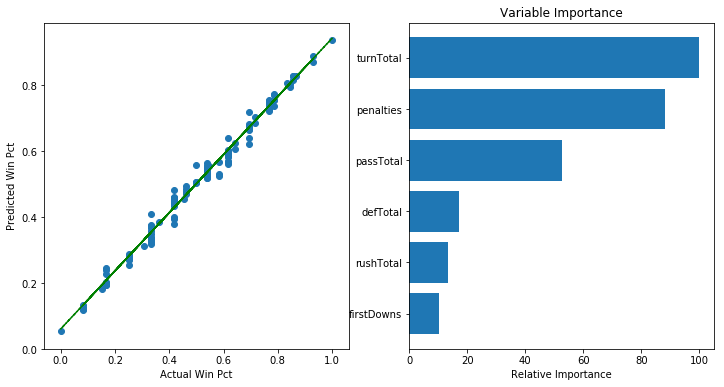

In [23]:
#pyplot
if doPlotting:
      
      def func(x, a, b):
            return (a * x) + b
      np_winpctArr = np.array(winPctArr)
      np_predictPct = np.array(predictPct)
      popt, pcov = curve_fit(func,np_winpctArr,np_predictPct)
      
      plt.figure(figsize=(12,6))
      plt.subplot(1,2,1)
      plt.scatter(winPctArr,predictPct)
      plt.plot(np_winpctArr, func(np_winpctArr, *popt), 'g--', label='linear fit')
      plt.xlabel("Actual Win Pct")
      plt.ylabel("Predicted Win Pct")
      
      if isGradientBoosted:
            feature_importance = clf.feature_importances_
            # make importances relative to max importance
            feature_importance = 100.0 * (feature_importance / feature_importance.max())
            sorted_idx = np.argsort(feature_importance)
            pos = np.arange(sorted_idx.shape[0]) + .5
            plt.subplot(1, 2, 2)
            plt.barh(pos, feature_importance[sorted_idx], align='center')
            print sorted_idx
            feature_names = [x for _,x in sorted(zip(sorted_idx,input_names))]
            plt.yticks(pos, feature_names)
            plt.xlabel('Relative Importance')
            plt.title('Variable Importance')
      
      plt.show()
      

In [24]:
iteam=0
for team in teams:
      print iteam+1, " ", sortedTeams[iteam], " (", '{0:.4f}'.format(sortedTeamDict[sortedTeams[iteam]]),")"
      iteam+=1

if(writeCSV):
      iteam=0
      fout = open('ranking_{year}.csv'.format(year=year),'w')
      fout.write("RANKING, TEAM, MVA SCORE\n")
      for team in teams:
            writeString = str(iteam+1)+", "+str(sortedTeams[iteam])+", "+'{0:.4f}'.format(sortedTeamDict[sortedTeams[iteam]])+'\n'
            fout.write(writeString)
            iteam+=1
      

1   central-florida  ( 0.9357 )
2   alabama  ( 0.8896 )
3   wisconsin  ( 0.8711 )
4   georgia  ( 0.8290 )
5   ohio-state  ( 0.8288 )
6   clemson  ( 0.8274 )
7   oklahoma  ( 0.8156 )
8   south-florida  ( 0.8061 )
9   penn-state  ( 0.8054 )
10   troy  ( 0.7933 )
11   florida-atlantic  ( 0.7746 )
12   boise-state  ( 0.7711 )
13   notre-dame  ( 0.7562 )
14   southern-california  ( 0.7546 )
15   texas-christian  ( 0.7542 )
16   oklahoma-state  ( 0.7526 )
17   memphis  ( 0.7470 )
18   michigan-state  ( 0.7417 )
19   toledo  ( 0.7383 )
20   washington  ( 0.7376 )
21   northwestern  ( 0.7327 )
22   army  ( 0.7290 )
23   miami-fl  ( 0.7290 )
24   san-diego-state  ( 0.7212 )
25   virginia-tech  ( 0.7204 )
26   fresno-state  ( 0.7036 )
27   auburn  ( 0.6856 )
28   louisiana-state  ( 0.6816 )
29   appalachian-state  ( 0.6767 )
30   mississippi-state  ( 0.6744 )
31   south-carolina  ( 0.6665 )
32   north-carolina-state  ( 0.6641 )
33   washington-state  ( 0.6413 )
34   louisville  ( 0.6400 )
35   n